## 初始化

In [1]:
from potential_initialization import *
from trap_model import *
%load_ext autoreload
%autoreload 2

In [2]:
# 缓存pseudo potential在一个字典中，若在调试时修改了trap_model的定义可以快速初始化
pbi= dict()

In [3]:
# 设置需要计算势场的区域
shuttle_range = [[-1, 1], [-0.1, 0.1], [0.05, 0.2]]
stepsize = 0.01
# rf电压和频率需要提前设置
V_rf = 170
omega_rf = 2 * np.pi * 30e6
# 初始化trap_model类型
junction = trap_model("junction", V_rf, omega_rf, shuttle_range, stepsize, pbi, regenerate=False)

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

## 设计sta路径

In [4]:
def shooting_palmero(l0, lf):
    def funcs(a10, a11):
        # l0 = 2*a0/mass*np.array([1, 3]) ## (-, +)
        # lf = 2*a0/mass*np.array([1, 1.002])
        gp, gm = (l0/lf)**0.25
        rho_m_t = lambda s, a10=a10, a11=a11: 1-(126*(1-gm) + a10 + 5*a11)*s**5 + (420*(1-gm) + 5*a10 + 24*a11)*s**6 - (540*(1-gm) + 10*a10 + 45*a11)*s**7 + (315*(1-gm) + 10*a10 + 40*a11)*s**8 - (70*(1-gm) + 5*a10 + 15*a11)*s**9 + a10*s**10 + a11*s**11
        rho_p_t = lambda s: 1+(gp-1)*(126*s**5-420*s**6+540*s**7-315*s**8+70*s**9)
        d2rho_mdt2 = lambda s: derivative(rho_m_t, s, n=2)
        d2rho_pdt2 = lambda s: derivative(rho_p_t, s, n=2)
        lm_t = lambda s: l0[1]*rho_m_t(s)**(-4) - d2rho_mdt2(s)/rho_m_t(s)
        lp_t = lambda s: l0[0]*rho_p_t(s)**(-4) - d2rho_pdt2(s)/rho_p_t(s)
        d_t = lambda s: (4*K/(mass*(lm_t(s)-lp_t(s))))**(1/3) ## SI units [m]
        s = np.linspace(0, 1, 3000)
        lm = lm_t(s)
        lm_t = ndsplines.make_interp_spline(s, lm)
        d = d_t(s)
        d_indterp = ndsplines.make_interp_spline(s, d*1e5)
        dtt = d_indterp.derivative(0).derivative(0)
        return dtt, lm_t
    
    def loss(v):
        T = 2e-5 * 5e5*2*np.pi / f0
        def func(s, v):
            xm, dxmdt = v
            return [dxmdt, -lm_t(s)*T**2*xm-(1/2)**0.5*d2dots(s)]
        a10, a11 = v
        d2dots, lm_t= funcs(a10, a11)
        sol = solve_ivp(func, t_span=(0, 1), y0=(0, 0))
        x = sol.y[0, -1]
        xdot = sol.y[1, -1]
        lm_f = lm_t(1) * T ** 2
        d2dots_f = d2dots(1)
        l = (xdot ** 2 + lm_f * (x-d2dots_f/2**0.5/lm_f)**2)
        print(l)
        return l

    mass = 171 * constants.atomic_mass
    eps0 = constants.epsilon_0
    K = constants.e**2/(4*np.pi*eps0)
    guess = (10, -10)
    return minimize(loss, guess, method='Nelder-Mead')

f0 = 1.5e5*2*np.pi
mass = 171 * constants.atomic_mass
eps0 = constants.epsilon_0
K = constants.e**2/(4*np.pi*eps0)
a0 = 0.5*mass*f0**2
l0 = 2*a0/mass*np.array([1, 3]) ## (-, +)
lf = 2*a0/mass*np.array([1, 1.002])
# ebeta = 6e4
# beta = constants.e * ebeta / 24 * 1e12
# d=(2*K/beta)**(1/5)
# lf = np.array([3*beta * d**2/mass, (3*beta*d**2+4*K/d**3)/mass])  
res = shooting_palmero(l0, lf)
para = res.x

C:\Users\TangGaoxiang\AppData\Local\Temp\ipykernel_23024\1134519496.py:8: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d2rho_mdt2 = lambda s: derivative(rho_m_t, s, n=2)
C:\Users\TangGaoxiang\AppData\Local\Temp\ipykernel_23024\1134519496.py:9: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d2rho_pdt2 = lambda s: derivative(rho_p_t, s, n=2)


126.19893439037646
116.31142080749251
228.13789110123219
77.941907499649
58.84643845274584
57.149916298700326
50.23930828225842
53.725176326326135
63.035926889081495
50.62471109818586
73.06240569304144
50.01888327369648
50.430537704052796
49.82731210758337
52.56835496425363
49.64695882170839
49.798607110972554
50.472322022640114
49.670407500119175
49.71874075195263
49.65689390127038
49.60960181347446
49.59272549695168
49.73576143311227
49.62654465967494
49.57490649367145
49.544804385321726
49.49947158264516
49.44152335685737
49.40385036782935
49.34643393535912
49.201247848829865
49.02513096571403
48.98636711272898
48.86658445751314
48.45089778344722
48.01174601650717
48.20225773325264
47.25937191516733
46.494626279420345
46.32041250518583
45.552666772657176
43.81835457222389
41.81228349814388
41.22740070645083
39.43819918425065
35.180408303609184
30.449942289837942
30.5729373106364
21.95514652692678
15.43156333121646
15.5340014169875
5.938491443026966
3.9601660883806455
25.421302762859

Text(0, 0.5, '$\\beta (V/mm^4)$')

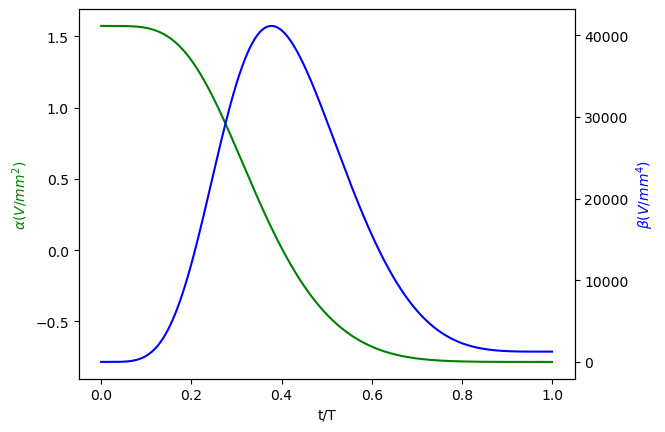

In [78]:
fig, ax1 = plt.subplots()

s = np.linspace(0, 1, 1000)
a, b, d = shuttle_protocols.split_sta_palmero(s, *res.x)
ax2 = ax1.twinx()
ax1.plot(s, a, 'g-')
ax2.plot(s, b, 'b-')

ax1.set_xlabel('t/T')
ax1.set_ylabel(r'$\alpha (V/mm^2)$ ', color='g')
ax2.set_ylabel(r'$\beta (V/mm^4)$', color='b')

## 结合具体的trap参数

In [ ]:
import shuttle_protocols
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
omega = np.array([0.5, 3, 3])
k = (m / q * (omega*1e6 * 2 * np.pi) ** 2) * 1e-6
k

array([ 17.52182675, 630.78576301, 630.78576301])

In [21]:
para

array([-637.46023912,  101.32052401])

0it [00:00, ?it/s]

9.420747548949828e-09
0.00012992592777966746
3.1972280473933814e-09
5.244170992066435e-09
0.0034141000398255454
1.816959734601774e-09
3.3315586595099772e-09
1.03540606512981e-08
5.523529256527966e-09
1.529493056843964e-08
3.1673231999165953e-08
5.3275639605821404e-08
3.168839301553441e-07
9.213264178475501e-08
1.0631354113139713e-07
1.1262487685499365e-07
1.0656707219515942e-07
1.0229127254991577e-07
9.170619435012602e-08
7.782149047468561e-08
6.248284588459706e-08
5.1218917375904355e-08
4.437549052324347e-08
2.972212940452756e-08
2.2472272608940746e-08
1.7820546287676895e-08
1.250974149167981e-08
9.522755341680058e-09
6.820721104333173e-09
5.2506747020570475e-09
1.3767056914479254e-08
3.798147997946064e-09
3.543459239960573e-09
3.257349100629156e-09
2.8912746857818434e-09
2.757640921538411e-09
3.9800446566956425e-09
4.412190007834874e-09
4.483761298433014e-09
3.6238872485000092e-09


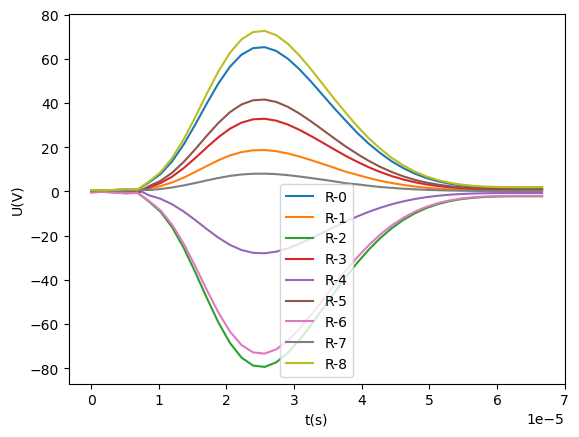

In [98]:
T, V = junction.optimize_splitting_profile(0.54, max_v=100, f0=0.15, top_nearest=9, deg=7)

In [90]:
tspan, y = junction.split_motion(0.54, T, V)

Text(0, 0.5, 'z(mm)')

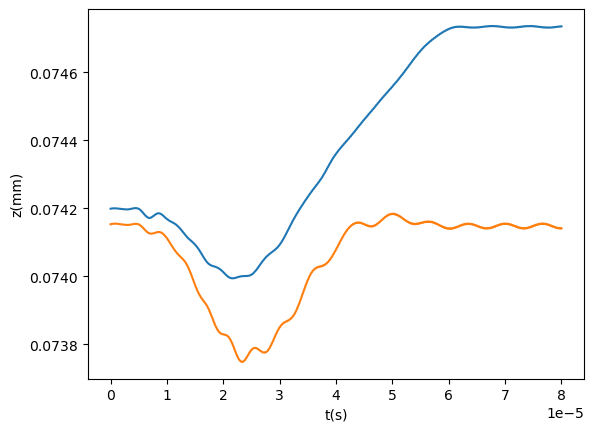

In [91]:
plt.plot(tspan, y[2])
plt.plot(tspan, y[5])
plt.xlabel('t(s)')
plt.ylabel('z(mm)')

Text(0, 0.5, 'x(mm)')

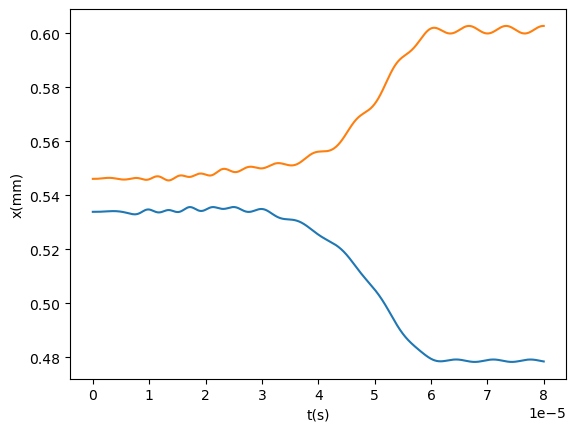

In [92]:
plt.plot(tspan, y[0])
plt.plot(tspan, y[3])
plt.xlabel('t(s)')
plt.ylabel('x(mm)')

In [93]:
heating0 = junction.heating_one_ion(tspan, T, y[0], freq=0.15e6*2*np.pi)
heating1 = junction.heating_one_ion(tspan, T, y[3], freq=0.15e6*2*np.pi)
heating0, heating1

(253.37842092544213, 2485.842608650261)

[-2.27243931e-04 -7.52088904e-01  2.95275694e-03  1.06854306e+03]


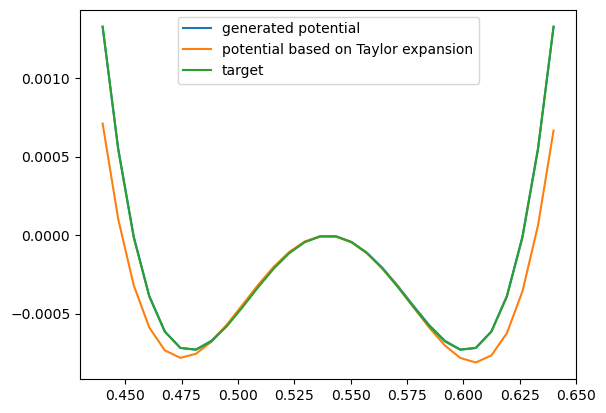

In [99]:
# v = junction.voltage({'R-4':20,'R-3':-21, 'R-5':-20, 'R-2':5, 'R-6':2.4})
a, b, d = shuttle_protocols.split_sta_palmero(np.linspace(0, 1, 40))
idx=-1
v, a, b = V[idx], a[idx], b[idx]
x0=0.54
xspan = np.linspace(x0-0.1, x0+0.1, 30)
junction.potential_curvature_x(v, xspan, label='generated potential')
# plt.vlines(x=x0, ymin=-0.1, ymax=0)
poly = junction.x_te(v, junction.rf_null_point(x0))
y0=junction.potential(v, junction.rf_null_point(x0))
func = lambda x, poly: y0+poly[0]*(x-x0)+poly[1]*(x-x0)**2/2+poly[2]*(x-x0)**3/6+poly[3]*(x-x0)**4/24
plt.plot(xspan, func(xspan, poly), label='potential based on Taylor expansion')
plt.plot(xspan, func(xspan, np.array([0, a, 0, b])), label='target')
plt.legend()
print(poly)

In [39]:
5e-3*1e-12*24/constants.e

748981.0889352915